In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

from pyspark.sql import SQLContext
from pyspark.sql import types
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType, FloatType


%matplotlib inline
plt.style.use('ggplot')

In [2]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)
SparkContext.setSystemProperty("spark.dynamicAllocation.enabled", "true")
sqlContext.setConf("spark.sql.shuffle.partitions", "5")


It's possible to read in data and just let PySpark take care of column types. 

* Pros: It's easy and less work that manually defining the schema
* Cons: It takes much longer time

In [3]:
start = time.time()
trips_df = spark.read.csv("gs://spark-taxi-analysis-data/trip_data/", 
                          inferSchema=True,
                          header=True)
print (f"This job was completed in {time.time() - start} seconds")

This job was completed in 153.39520144462585 seconds


In [4]:
# Or we manually define the schema
trips_df_schema = StructType(
    [StructField("VendorID", IntegerType(), True),
     StructField("tpep_pickup_datetime", TimestampType(), True),
     StructField("tpep_dropoff_datetime", TimestampType(), True),
     StructField("passenger_count", IntegerType(), True),
     StructField("trip_distance", FloatType(), True),
     StructField("RatecodeID", IntegerType(), True),    
     StructField("store_and_fwd_flag", StringType(), True),
     StructField("PULocationID", IntegerType(), True),
     StructField("DOLocationID", IntegerType(), True),
     StructField("payment_type", IntegerType(), True),
     StructField("fare_amount", FloatType(), True),
     StructField("extra", FloatType(), True),
     StructField("mta_tax", FloatType(), True),
     StructField("tip_amount", FloatType(), True),
     StructField("tolls_amount", FloatType(), True),
     StructField("improvement_surcharge", FloatType(), True),
     StructField("total_amount", FloatType(), True)])

start = time.time()
trips_df = spark.read.csv("gs://spark-taxi-analysis-data/trip_data/", 
                          schema=trips_df_schema,
                          header=True)
print (f"This job was completed in {time.time() - start} seconds")

This job was completed in 0.2892448902130127 seconds


The difference in time is obvious. 

When using Spark for production ETL, it is often a good idea to define the schema manually, especially when working with untyped data sources liked CSV or JSON because schema inference can vary depending on the type of data that you read in.

In [5]:
print(trips_df.rdd.getNumPartitions())

60


In [7]:
print (f"Number of rows: {trips_df.count()}")
print (f"Number of columns: {len(trips_df.columns)}")
print (f"Names of columns: {trips_df.columns}")

Number of rows: 84399019
 
Number of columns: 17
 
Names of columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
 


In [8]:
# To remove the duplicate rows
print (f'Before removing duplicates: {trips_df.count()} rows')
trips_df_no_duplicates = trips_df.dropDuplicates()
print (f'After removing duplicates: {trips_df_no_duplicates.count()} rows')

Before removing duplicates: 84399019 rows
After removing duplicates: 84398969 rows


In [9]:
# Add additional datasets for further joins 
# Read in all of the data
loc_df = spark.read \
              .option("header", "true") \
              .option("inferSchema", "true") \
              .csv("gs://spark-taxi-analysis-data/nyc_taxi_zones")

stations_df = spark.read \
                   .option("header", "true") \
                   .option("inferSchema", "true") \
                   .csv("gs://spark-taxi-analysis-data/noaa_stations")

weather_df = spark.read \
                  .option("header", "true") \
                  .option("inferSchema", "true") \
                  .csv("gs://spark-taxi-analysis-data/noass_gsod_2019")

In [10]:
trips_df.registerTempTable("trips")
loc_df.registerTempTable("taxi_locations")
stations_df.registerTempTable("weather_stations")
weather_df.registerTempTable("weather")

In [11]:
print ('Trips: ', list(trips_df.columns))
print ('\n')
print('Taxi Locations: ', list(loc_df.columns))
print ('\n')
print('Weather stations: ', list(stations_df.columns))
print ('\n')
print('Weather: ', list(weather_df.columns))
print ('\n')

Trips:  ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']


Taxi Locations:  ['zone_id', 'zone_name', 'borough', 'zone_geom']


Weather stations:  ['usaf', 'wban', 'name', 'country', 'state', 'call', 'lat', 'lon', 'elev', 'begin', 'end']


Weather:  ['stn', 'wban', 'year', 'mo', 'da', 'temp', 'count_temp', 'dewp', 'count_dewp', 'slp', 'count_slp', 'stp', 'count_stp', 'visib', 'count_visib', 'wdsp', 'count_wdsp', 'mxpsd', 'gust', 'max', 'flag_max', 'min', 'flag_min', 'prcp', 'flag_prcp', 'sndp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder', 'tornado_funnel_cloud']




We can combine all of the dataframes into one using SQL JOINs commands.

For that, we need to:
* Identify the common columns that can be used to join together. This approach is not very SQL as to join tables in SQL, you need to use the concept of keys; not the case in DFs/PySpark
* Inspect those columns in the actual dataframes, and maybe filter them


I will start with weather_stations and weather and display all the column names that are common for those DFs

In [18]:
query = """
    WITH daily_weather AS 
    (
    SELECT
        TO_DATE(CAST(UNIX_TIMESTAMP(CONCAT(w.mo,'/',w.da,'/',w.year), 'MM/dd/yyyy') AS TIMESTAMP)) AS weather_date,
        w.temp AS avg_temp,
        w.max AS max_temp,
        w.min AS min_temp,
        w.prcp AS perception_inch,
        w.sndp AS snow_depth,
        w.fog, w.rain_drizzle, 
        w.snow_ice_pellets,
        w.hail, w.thunder, w.tornado_funnel_cloud,
        w.wdsp AS wind_speed,
        w.visib
    FROM
        weather AS w
    WHERE 
        w.wban IN (SELECT ws.wban 
                   FROM weather_stations as WS
                   WHERE ws.country = 'US' AND ws.state = 'NY' and ws.call = 'KNYC')),
yellow_trips AS
    (
    SELECT
        t.VendorID AS vendor_id,
        TO_DATE(t.tpep_pickup_datetime) as pickup_date,
        TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
        t.passenger_count, 
        t.trip_distance, 
        t.RatecodeID as ratecodeid,
        t.store_and_fwd_flag,
        t.payment_type, 
        t.fare_amount, 
        t.extra, 
        t.mta_tax,
        t.tip_amount, 
        t.tolls_amount, 
        t.improvement_surcharge,
        t.total_amount, 
        t.PULocationID,
        t.DOLocationID,
        ptloc.zone_name as pickup_zone,
        ptloc.borough AS pickup_borough,
        dtloc.zone_name as dropoff_zone,
        dtloc.borough AS dropoff_borough
    FROM
        trips AS t
    LEFT JOIN
        taxi_locations AS ptloc
        ON
            ptloc.zone_id = t.PULocationID
    LEFT JOIN
        taxi_locations as dtloc
        ON
            dtloc.zone_id = t.DOLocationID)
SELECT
        yt.vendor_id,
        yt.pickup_date,
        yt.dropoff_date,
        yt.passenger_count, 
        yt.trip_distance, 
        yt.RatecodeID as ratecodeid,
        yt.store_and_fwd_flag,
        yt.payment_type, 
        yt.fare_amount, 
        yt.extra, 
        yt.mta_tax,
        yt.tip_amount, 
        yt.tolls_amount, 
        yt.improvement_surcharge,
        yt.total_amount, 
        yt.dropoff_zone,
        yt.pickup_borough,
        yt.pickup_zone,
        yt.PULocationID,
        yt.DOLocationID,  
        yt.dropoff_borough,
        dw.avg_temp,
        dw.max_temp,
        dw.min_temp,
        dw.perception_inch,
        dw.snow_depth,
        dw.fog, 
        dw.rain_drizzle, 
        dw.snow_ice_pellets,
        dw.hail, 
        dw.thunder, 
        dw.tornado_funnel_cloud,
        dw.wind_speed,
        dw.visib
    FROM
        yellow_trips AS yt
    LEFT JOIN
        daily_weather AS dw
        ON
            dw.weather_date = yt.pickup_date
    ORDER BY pickup_date DESC
"""

testing_df = spark.sql(query)
testing_df.limit(10).toPandas()

,vendor_id,pickup_date,dropoff_date,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,payment_type,fare_amount,extra,...,perception_inch,snow_depth,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud,wind_speed,visib
0,2,2090-12-31,2090-12-31,2,18.600000,2,N,2,52.0,0.0,...,None,None,None,None,None,None,None,None,None,None
1,2,2088-01-24,2088-01-24,1,0.630000,1,N,2,4.5,0.0,...,None,None,None,None,None,None,None,None,None,None
2,2,2088-01-24,2088-01-24,1,4.050000,1,N,2,14.5,0.0,...,None,None,None,None,None,None,None,None,None,None
3,2,2066-12-17,2066-12-17,2,16.139999,2,N,2,52.0,0.0,...,None,None,None,None,None,None,None,None,None,None
4,2,2058-12-02,2058-12-02,1,1.030000,1,N,2,5.0,0.5,...,None,None,None,None,None,None,None,None,None,None
5,2,2058-12-02,2058-12-02,1,1.600000,1,N,1,8.0,0.5,...,None,None,None,None,None,None,None,None,None,None
6,2,2058-12-02,2058-12-02,1,1.260000,1,N,2,8.5,0.0,...,None,None,None,None,None,None,None,None,None,None
7,2,2041-03-25,2041-03-25,2,2.850000,1,N,1,10.5,2.5,...,None,None,None,None,None,None,None,None,None,None
8,2,2038-02-17,2038-02-17,1,0.450000,1,N,2,4.0,0.5,...,None,None,None,None,None,None,None,None,None,None
9,2,2038-02-17,2038-02-18,1,0.560000,1,N,1,4.0,0.5,...,None,None,None,None,None,None,None,None,None,None


It's obvious that something is up with dates. 

Not a problem, we can filter those out, along with other anomalies

In [22]:
combined_df = testing_df

## Data Check

There is already an obvious problem with years. Let's see other problems that might exist

In [ ]:
combined_df_stats = combined_df.describe().toPandas()

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
combined_df_stats

,summary,vendor_id,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,dropoff_zone,pickup_borough,pickup_zone,PULocationID,DOLocationID,dropoff_borough,avg_temp,max_temp,min_temp,perception_inch,snow_depth,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud,wind_speed,visib
0,count,84190934,84190934,84439371,84190934,84190934,84190934,84439371,84439371,84439371,84439371,84439371,84439371,84439371,83448763,83605277,83605277,84439371,84439371,83448763,84437928,84437928,84437928,84437928,84437928,84437928,84437928,84437928,84437928,84437928,84437928,84437928,84437928
1,mean,1.6455026262091355,1.5626759052227643,3.00318068556166,1.0613860632547443,None,1.2895365432102226,13.350946967563337,1.0863997481679055,0.4946019680796163,2.194803511455032,0.383271993718813,0.298602842528363,19.13089236234556,None,None,None,163.13770975390142,161.31052577357545,None,54.48115565864302,63.976128864140684,46.15663034202275,0.15763691832974927,966.421496692563,0.09883249385276247,0.42989338866770865,0.07013578068850766,0.0,0.0,0.0,210.68000637835496,9.043030810980218
2,stddev,0.49786371967522963,1.207887614228836,8.090213774168298,0.7597189351163184,None,0.47923902619636194,174.33379848584252,1.248556747604604,0.06731118084151577,15.653542362965691,1.8178157102559434,0.0279103704351995,184.04404364778625,None,None,None,66.01772370463704,70.26770474222666,None,17.04009360192608,17.7947806595246,16.76158152030007,0.33139798442095597,179.7105248740387,0.2984369834092337,0.49506066895892437,0.25537571092037314,0.0,0.0,0.0,403.82076208907233,1.5386054042183055
3,min,1,0,-37264.53,1,N,1,-1856.0,-60.0,-0.5,-221.0,-70.0,-0.3,-1871.8,Allerton/Pelham Gardens,Bronx,Allerton/Pelham Gardens,1,1,Bronx,8.4,15.1,1.9,0.0,1.2,0,0,0,0,0,0,0.7,2.4
4,max,4,9,45977.22,99,Y,5,943274.8,535.38,212.42,141492.02,3288.0,1.0,1084772.1,Yorkville West,Staten Island,Yorkville West,265,265,Staten Island,88.7,95.0,82.0,2.19,999.9,1,1,1,0,0,0,999.9,10.0


I was looking at min-max values and here are couple of filters that can be implemented immediately:
* Trip_distance: Should be more than 0 but less than 200; I cannot imagine anyone taking a trip for more than 200 miles (I can assume that 200 miles is for trips between cities)
* Fare_amout: anything more than 0 and less than 1000 USD should do
* Tip_amount: I will limit those to [0, 500] USD
* Year: we need to limit to 2019 only
* Total amount: should be more than 0 but less than 1500 USD (I assume that tips might be large for that trip)
* I could filter also wind_speed, snow_depth but I will leave them for now

In [30]:
combined_df.registerTempTable("combo")

In [31]:
query = """
SELECT
    *
FROM
    combo c
WHERE 
    c.total_amount < 10000
    AND c.fare_amount > 0 AND c.fare_amount < 1000
    AND c.tip_amount > 0 AND c.tip_amount < 500
    AND c.total_amount > 0 AND c.total_amount < 1500
    AND c.trip_distance > 0 AND c.trip_distance < 100
    AND c.pickup_date >= '2019-01-01'
    AND c.pickup_date < '2019-12-31'
"""
# create a new DataFrame based on the query
combined_df = spark.sql(query)

That was the first stage in filtering out the obvious anomalies.

Further analysis is needed

In [57]:
combined_df.registerTempTable("combo")

## EDA

By itself, EDA could have been used to find and filter out anomalies but here, I am using it to derive insights from data

### How has the number of trips changed over the time?

I want to know what months has the maximum number of trips. It could be useful to test the hypothesis that the months with the most public events (concerts, sport events) will drive up the number of trips

In [66]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'MMM') AS date_month,
    ROUND(COUNT(*)/1000, 2) AS trip_count_number
FROM
    combo c
GROUP BY
    c.pickup_date,
    date_month
"""

number_trips_month = spark.sql(query).toPandas()

In [67]:
number_trips_month.sort_values(by='pickup_date', inplace=True)

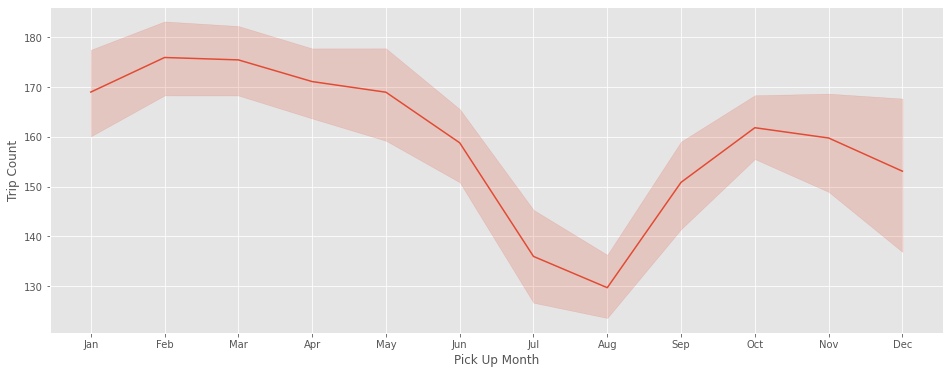

In [69]:
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x='date_month', y='trip_count_number', data=number_trips_month, ax=ax)

ax.set_ylabel("Trip Count")
ax.set_xlabel("Pick Up Month")

plt.show()

October and November have the highest number of trips. 

It could be because of Halloween and Thanskgiving and various sport events (Nets vs. Knicks, Giant vs. Jets). To derive a little more insights, we can take a look at days with most trips.

In [58]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'd MMM') AS day_of_week,
    ROUND(COUNT(*)/1000, 2) AS trip_count_number
FROM
    combo c
GROUP BY
    c.pickup_date,
    day_of_week
ORDER BY
    day_of_week
"""

number_trips_days = spark.sql(query).toPandas()

In [61]:
number_trips_days.sort_values(by='pickup_date', inplace=True)

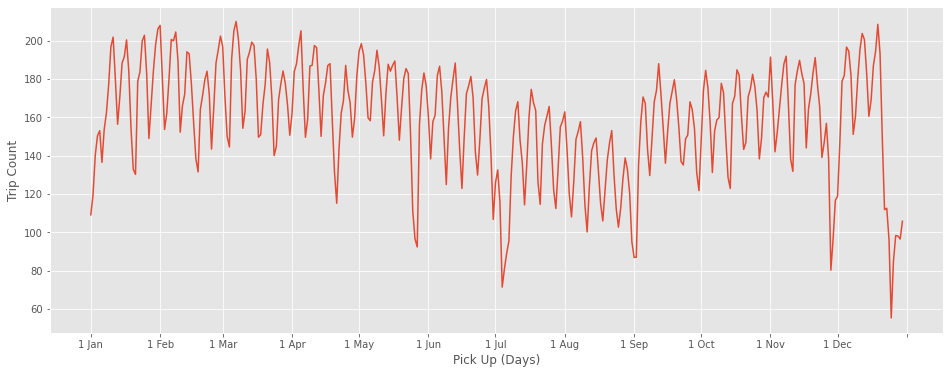

In [62]:
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x='day_of_week', y='trip_count_number', data=number_trips_days, ax=ax)

ax.set_ylabel("Trip Count")
ax.set_xlabel("Pick Up (Days)")
ax.xaxis.set_major_locator(mdates.MonthLocator())


plt.show()

It's pretty interesting. As it shows that the maximum number of trips was around mid-December, which can be explained by Christmas shopping.

In regards to October, it seems like the peak was around the end of the month, which can be explained by Halloween.

In regards to November, I was surprised not to see the peak around Thanksgiving

It would be also interesting to analyze what days are the most popular for taking a taxi. I would expect it to be either Thursday, or Friday, mainly due to people going out to bars/clubs. In Houston, drinks were cheaper on Thursdays, and if that's the case in NYC, then high number trips on Thursday will make sense.

In [70]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    ROUND(COUNT(*)/1000, 2) AS trip_count_number
FROM
    combo c
GROUP BY
    c.pickup_date,
    day_of_week
ORDER BY
    day_of_week
"""

number_trips_days_week = spark.sql(query).toPandas()

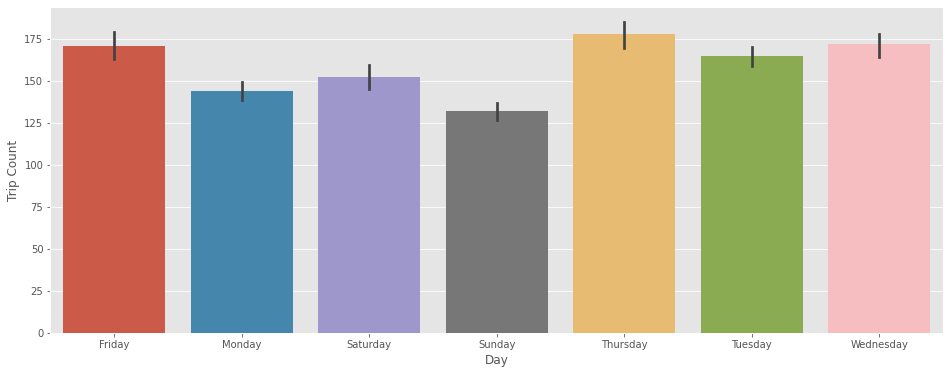

In [74]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x='day_of_week', y='trip_count_number', 
            data=number_trips_days_week, 
            ax=ax)

ax.set_ylabel("Trip Count")
ax.set_xlabel("Day")


plt.show()


Would be interesting to see what payment method people prefer. I can predit that due to trips happening in North America, credit cards would be prevalent

In [77]:
query = """
SELECT
    CASE WHEN c.payment_type = 1 THEN "Credit Card"
         WHEN c.payment_type = 2 THEN "Cash"
         WHEN c.payment_type = 3 THEN "No Charge"
         WHEN c.payment_type = 4 THEN "Dispute"
         WHEN c.payment_type = 5 THEN "Unknown"
         WHEN c.payment_type = 6 THEN "Voided Trip" 
         END AS payment_type,
    COUNT(*) AS trip_count    
FROM
    combo c
GROUP BY 
    payment_type
"""

prefered_payment_method = spark.sql(query).toPandas()

In [81]:
prefered_payment_method.sort_values(by='trip_count', ascending=False)

,payment_type,trip_count
4,Credit Card,57898113
5,Cash,2306
3,None,1411
0,No Charge,240
2,Dispute,116
1,Unknown,1


Another thing that I would be curious to see is the effect of the weather on the trips. On one hand, the worse weather will increase the frequency of the trips; on the other hand, if it's expected to have a bad weather, unnecessary trips can be cancelled.

In [ ]:
query = """
SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    MEAN(c.avg_temp) AS mean_temp,
    MEAN(c.perception_inch) AS mean_percip_inch,
    MEAN(c.snow_depth) AS mean_snow_depth,
    MEAN(c.fog) as mean_fog,
    MEAN(c.rain_drizzle) AS mean_rain_drizzle,
    MEAN(c.snow_ice_pellets) AS mean_snow_ice_pellets,
    MEAN(c.hail) AS mean_hail,
    MEAN(c.thunder) AS mean_thunder,
    MEAN(c.wind_speed) AS mean_wind_speed,
    ROUND(COUNT(*)/1000, 2) AS trip_counts
FROM
    combo c
GROUP BY
    c.pickup_date,
    day_of_week    
"""

effect_of_weather_df = spark.sql(query).toPandas()

In [98]:
effect_of_weather_df.drop(['pickup_date', 'day_of_week'],axis=1, inplace=True)


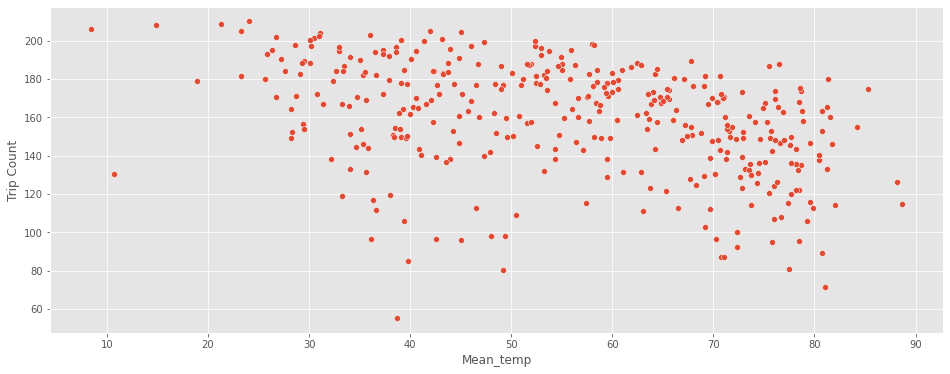

In [90]:
fig, ax = plt.subplots(figsize=(16,6))
sns.scatterplot(x='mean_temp', 
                y='trip_counts', 
                data=effect_of_weather_df, 
                ax=ax)

ax.set_ylabel("Trip Count")
ax.set_xlabel("Mean_temp")

plt.show()

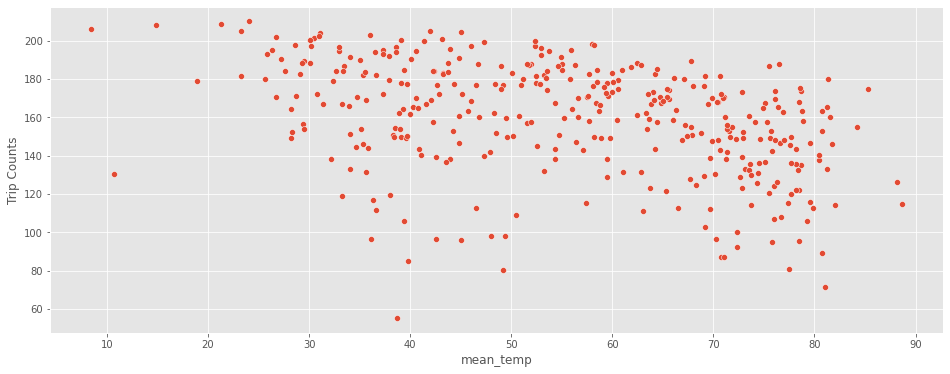

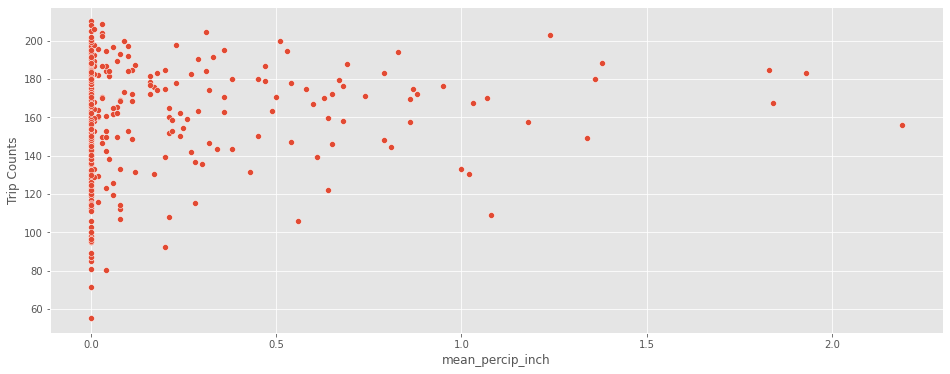

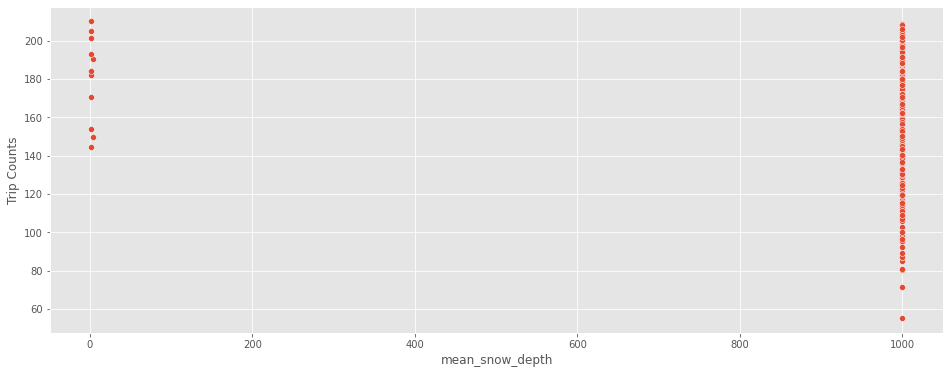

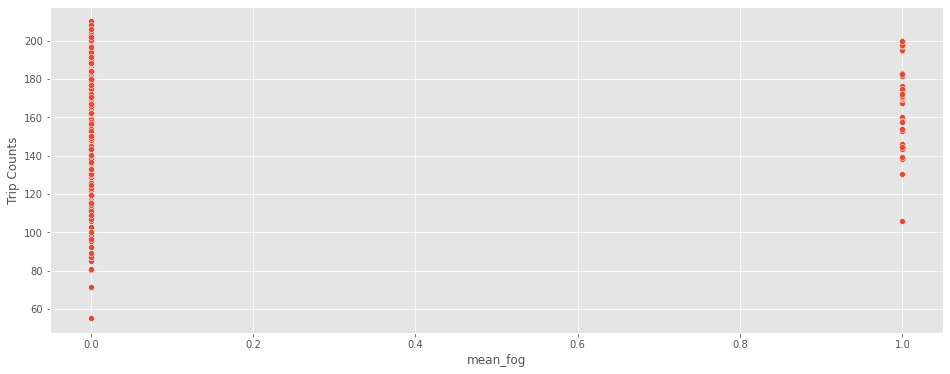

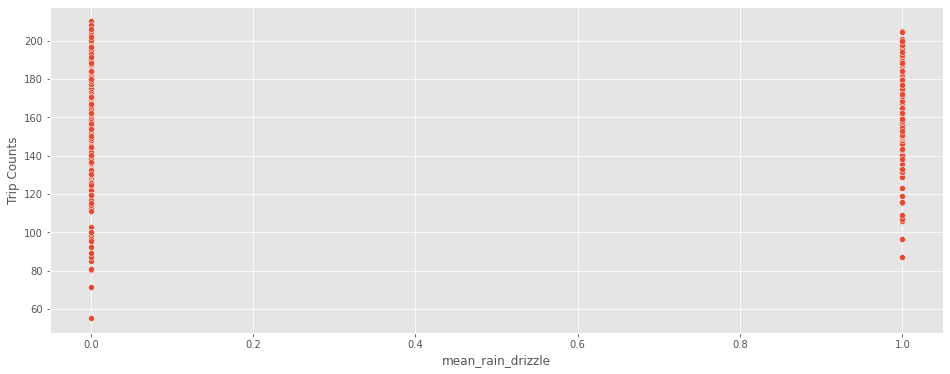

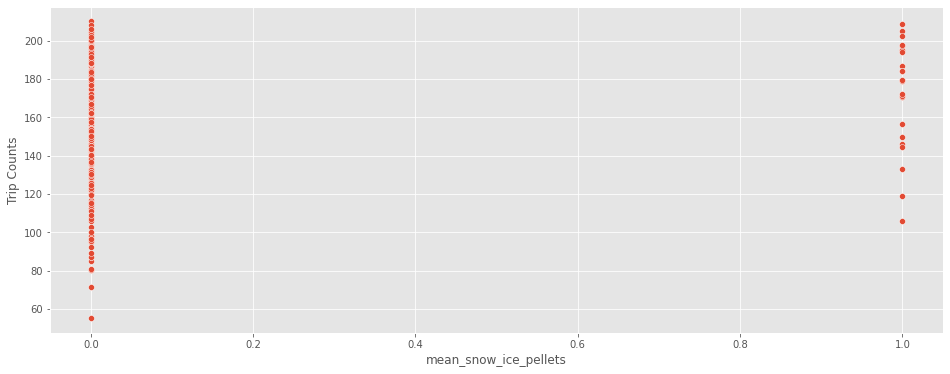

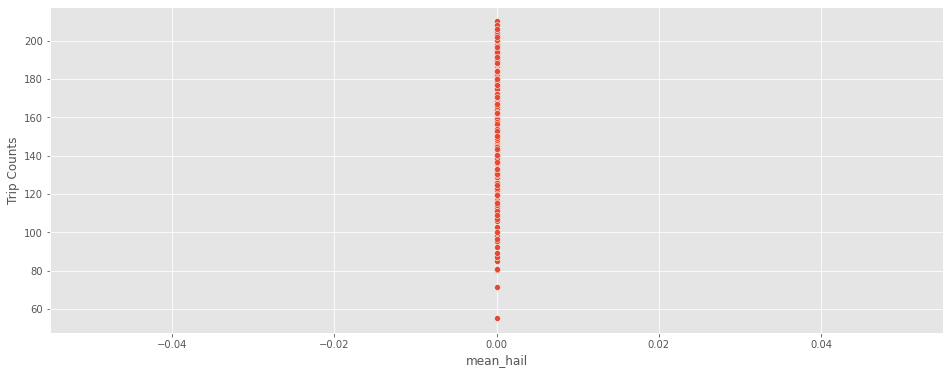

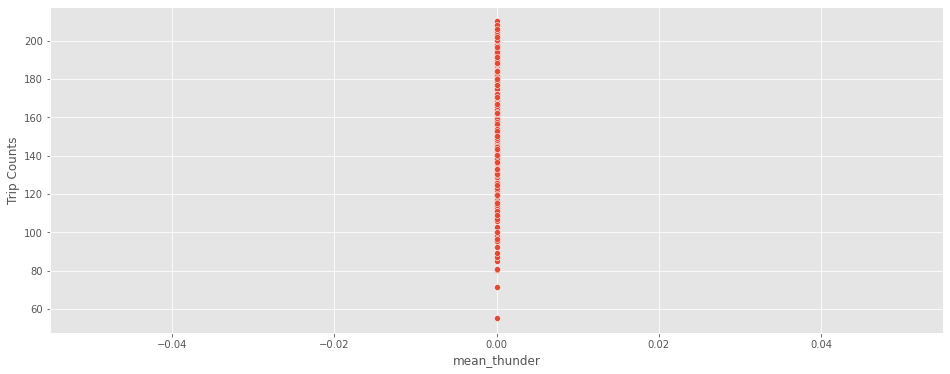

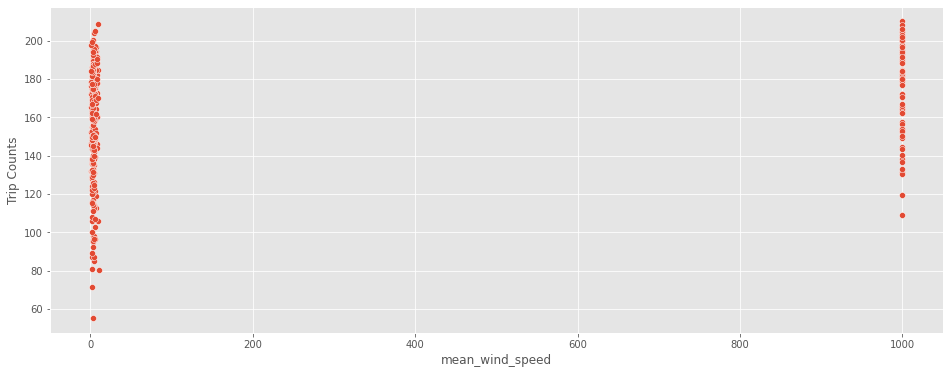

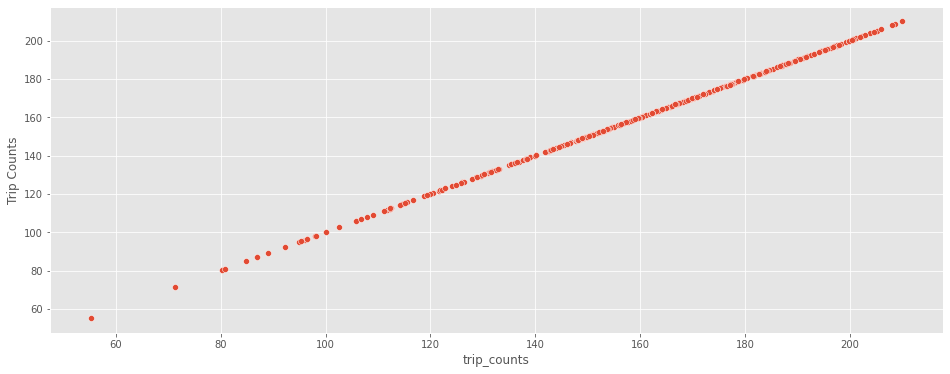

In [99]:
for col_name in effect_of_weather_df:
    fig, ax = plt.subplots(figsize=(16,6))
    if col_name is not 'trip_counts':
        sns.scatterplot(x=col_name, 
                        y='trip_counts', 
                        data=effect_of_weather_df, 
                        ax=ax)
        ax.set_ylabel('Trip Counts')
        ax.set_xlabel(col_name)

        plt.show()


To save our work so far, we can save the file as Hadoop columnar storage format

In [ ]:
combined_df.write.format("parquet").save("gs://spark-taxi-analysis-data/final_df")